In [1]:
from get_albedo import *

import matplotlib.pyplot as plt
%matplotlib inline


Bad key "axes.spines.right" on line 223 in
/home/nicola/python/eoldas/two_stream/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "axes.spines.top" on line 224 in
/home/nicola/python/eoldas/two_stream/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "axes.prop_cycle" on line 214 in
/home/nicola/python/eoldas/two_stream/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution


In [2]:
fieldname = "Northampton_LowerFarm"
yearrange = [2005,2015]

In [3]:
alldata = []
obs = Observations("albedo_tests.sql")
for year in xrange(*yearrange):
    print year
    x = obs.query(year, fieldname, -0.863234, 52.186673)
    alldata.append(x)
    #print x

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=medium. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=large. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


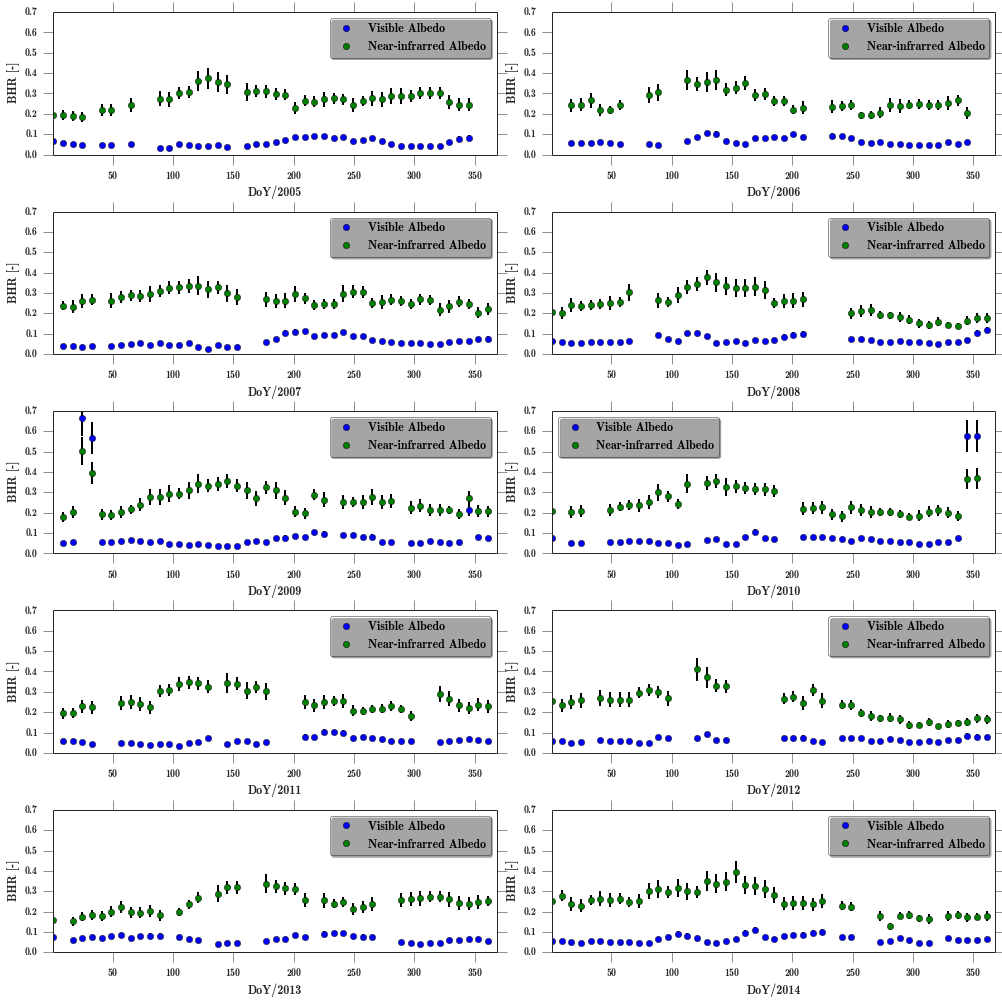

In [4]:
from da_functions import visualise_albedos
from tip_helpers import retrieve_albedo

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14,14))
axs= axs.flatten()

for year, ax in zip(xrange(*yearrange), axs):
    print year
    
    observations, mask, bu, passer_snow = retrieve_albedo ( year, fieldname,
                                                       albedo_unc=[0.05, 0.07])
    passer = mask[:,1] == 1
    doys = mask[:, 0]
    #plt.figure ( figsize=(12,6))
    ax.plot ( doys[passer], observations[passer, 0], 'o', label="Visible Albedo")
    ax.plot ( doys[passer], observations[passer, 1], 'o', label="Near-infrarred Albedo")
    ax.vlines ( doys[passer], observations[passer, 0] + 1.96*bu[passer,0],
                 observations[passer, 0] - 1.96 * bu[passer, 0])
    ax.vlines ( doys[passer], observations[passer, 1] + 1.96*bu[passer,1],
                 observations[passer, 1] - 1.96 * bu[passer, 1])
    ax.legend(loc="best", numpoints=1, fancybox=True, shadow=True)
    ax.set_ylabel("BHR [-]")
    ax.set_xlabel("DoY/%d" % year )
    ax.set_xlim ( 1, 368)
    ax.set_ylim ( 0, 0.7)
 
fig.tight_layout()
#visualise_albedos("Northampton_LowerFarm", year)


In [5]:
from da_functions import regularised_tip_inversion, tip_inversion

def regularised_inversion ( fluxnet_site, year, green_leaves, gamma_lai,
                                       n_tries=5, albedo_unc=[0.05, 0.07] ):

    
    retval_s, state, obs = tip_inversion( year, fluxnet_site, green_leaves=green_leaves,
                                          n_tries=n_tries )
    mu = state.operators['Prior'].mu
    cinv = state.operators['Prior'].inv_cov
    c = np.array(np.sqrt(np.linalg.inv (cinv.todense()).diagonal())).squeeze()
    post_sd = np.sqrt(np.array(retval_s['post_cov'].todense()).squeeze())
    post_sd_single = np.where(post_sd > c, c, post_sd)

    
    retval, state, obs = regularised_tip_inversion( year, fluxnet_site, [1e-3, 0, 0.1, 1e-3, 0, 0.1, gamma_lai  ],
                                                    x0=retval_s['real_map'], green_leaves=green_leaves,
                                                    n_tries=n_tries, albedo_unc=albedo_unc )
    mu = state.operators['Prior'].mu
    cinv = state.operators['Prior'].inv_cov
    c = np.array(np.sqrt(np.linalg.inv (cinv.todense()).diagonal())).squeeze()
    post_sd = np.sqrt(np.array(retval['post_cov'].todense()).squeeze())
    post_sd = np.where(post_sd > c, c, post_sd)
    return retval, state, obs, mu, post_sd

In [6]:
retvals = []
states = []
post_sds = []
#fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14,14))
#axs= axs.flatten()
for year, ax in zip(xrange(2005,2015), axs):
    print year
    retval, state, obs, mu, post_sd = regularised_inversion(
        "Northampton_LowerFarm", year, green_leaves=False, gamma_lai=1, n_tries=10)
    retvals.append(retval)
    states.append(state)
    post_sds.append(post_sd)
    
    
    #i = 6
    #ax.fill_between ( state.state_grid, retval['real_map']['lai'] - post_sd[(i*46):((i+1)*46)],
    #                        retval['real_map']['lai'] + post_sd[(i*46):((i+1)*46)], lw=0.8, color="0.8")
    #ax.plot(state.state_grid, retval['real_map']['lai'], 'o-', mfc="none")
    #ax.set_xlim([-2, 4])

2005
Saving results to eoldas_retval_20161206_163735_SH97R
[18.681607828547303, 18.676320975457021, 18.408243098588027, 18.282732228876736, 19.123709860219158, 18.356175428778325, 18.331297037621685, 18.37531381257531, 18.452328241563674, 18.320811016089483]
Chosen cost: 18.2827
Saving results to eoldas_retval_20161206_163839_SH97R
[20.399345542667962, 20.379350825420051, 20.71432310788461, 22.305315922713806, 22.274709231856971, 22.20339632479774, 20.344626949828729, 20.360279952189124, 20.571855638870829, 20.448305329059586]
Chosen cost: 20.3446
2006
Saving results to eoldas_retval_20161206_163935_SH97R
[15.181658066682299, 15.522575460936309, 15.531723051199737, 15.423349530206785, 15.177384657708057, 38.194628387680432, 34.720492756714471, 49.917858761385524, 15.10655076558854, 15.675959377697167]
Chosen cost: 15.1066
Saving results to eoldas_retval_20161206_164035_SH97R
[17.465297239601629, 16.981086284381895, 17.504352390307258, 16.915257594385857, 17.034736618199467, 17.17110311

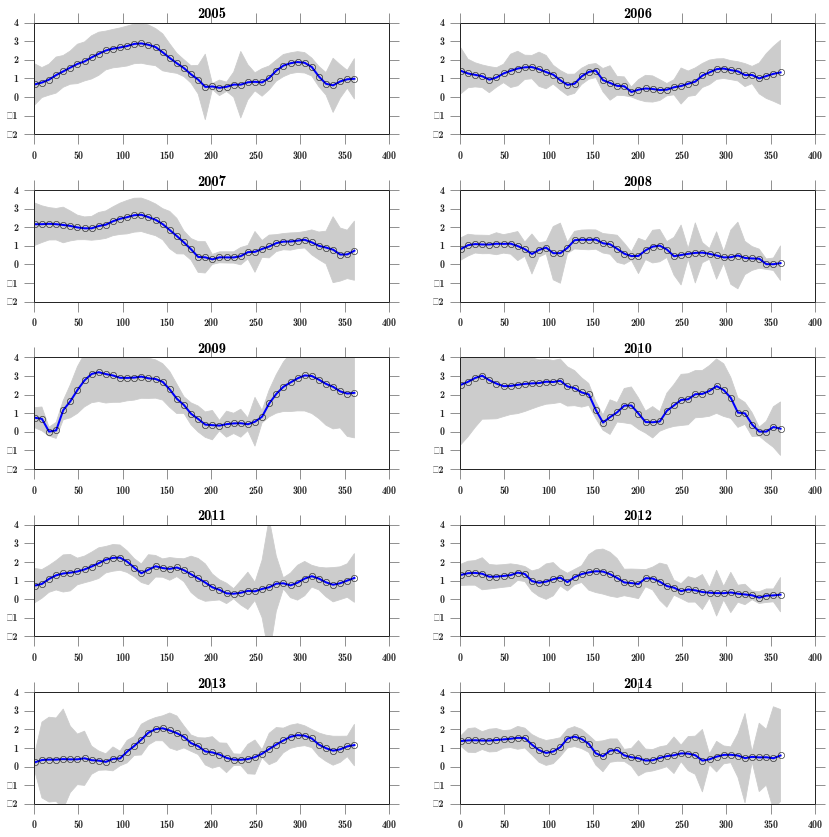

In [15]:
 
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14,14))
axs = axs.flatten()
for state, retval, post_sd, ax, year in zip(states, retvals, post_sds, axs, xrange(*yearrange)):
    i = 6
    ax.fill_between ( state.state_grid, retval['real_map']['lai'] - post_sd[(i*46):((i+1)*46)],
                            retval['real_map']['lai'] + post_sd[(i*46):((i+1)*46)], lw=0.8, color="0.8")
    ax.plot(state.state_grid, retval['real_map']['lai'], 'o-', mfc="none")
    ax.set_ylim([-2, 4])
    ax.set_title(year)

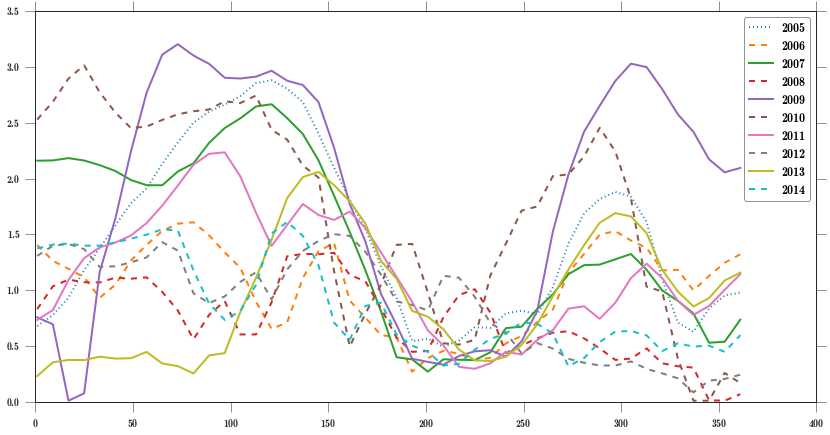

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
line_style = [':', '--', '-', '--', '-', '--', '-', '--', '-', '--', '-', '--', '-']

for state, retval, c, l in zip(states, retvals, new_colors, line_style):
    
    #i = 6
    #ax.fill_between ( state.state_grid, retval['real_map']['lai'] - post_sd[(i*46):((i+1)*46)],
    #                        retval['real_map']['lai'] + post_sd[(i*46):((i+1)*46)], lw=0.8, color="0.8")
    ax.plot(state.state_grid, retval['real_map']['lai'], l, mfc="none", color=c)
ax.legend (range(*yearrange))

In [1]:


import cPickle as pickle 

data = pickle.load(open('eoldas_retval_20161201_131221_SH97R.pkl'))

In [21]:
print data['real_map'].keys()
data['hessian'].todense()


['omega_vis', 'd_vis', 'a_vis', 'omega_nir', 'd_nir', 'a_nir', 'lai']


matrix([[  1.00533964e+04,  -1.00000000e-03,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [ -1.00000000e-03,   3.17566131e+03,  -1.00000000e-03, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,  -1.00000000e-03,   3.40352497e+03, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           1.52124026e+02,  -1.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          -1.00000000e+00,   9.14282312e+01,  -1.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,  -1.00000000e+00,   1.04000000e+00]])